# Practica 2: Modelos de Clasificacion de Credito - COMPLETA

**Objetivo:** Implementar y optimizar modelos para clasificacion binaria.

**Contexto:** Coste de FP (dar credito no devuelto) = 4x coste FN (no dar credito devuelto).

In [1]:
import pandas as pd     # Manipulación y análisis de datos
import numpy as np      # Cálculos numéricos  
import matplotlib.pyplot as plt # Visualización de datos
import seaborn as sns   # Visualización de datos avanzada
import warnings         # Manejo de advertencias
warnings.filterwarnings('ignore') 

# Importación de librerías de Scikit-Learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
#trein_test_split divide el conjunto de datos en conjuntos de entrenamiento y prueba
#cross_val_score evalúa un modelo utilizando validación cruzada
#GridSearchCV realiza una búsqueda para encontrar los mejores hiperparámetros
#StratifiedKFold proporciona divisiones en K pliegues estratificados

from sklearn.preprocessing import StandardScaler, OneHotEncoder
#StandardScaler Normaliza variables numéricas (media 0, varianza 1)
#OneHotEncoder Convierte variables categóricas en variables binarias.

from sklearn.compose import ColumnTransformer   
#Permite aplicar varios transformadores a distintas columnas del dataset.

from sklearn.pipeline import Pipeline
#Conecta pasos secuenciales: preprocesamiento → modelo.

from sklearn.linear_model import LogisticRegression
#Regresión logística para clasificación binaria y multiclase

from sklearn.tree import DecisionTreeClassifier
#Árboles de decisión para clasificación y regresión

from sklearn.neighbors import KNeighborsClassifier
#Clasificador basado en la proximidad de los vecinos más cercanos

from sklearn.naive_bayes import GaussianNB
#Clasificador basado en el teorema de Bayes con suposiciones gaussianas

from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)
#Métricas para evaluar el rendimiento de modelos de clasificación
    #classification_report Resumen de métricas de clasificación
    #confusion_matrix Matriz de confusión
    #roc_auc_score Área bajo la curva ROC
    #roc_curve Curva ROC
    #accuracy_score Precisión del modelo
    #precision_score Precisión del modelo
    #recall_score Exhaustividad del modelo
    #f1_score Puntuación F1 del modelo

%matplotlib inline
# Configuración de estilos de visualización

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print('LIBRERIAS IMPORTADAS')

LIBRERIAS IMPORTADAS


## Apartado A: Analisis Exploratorio (EDA)


DISTRIBUCION DE CLASES:
returned_credit
1    700
0    300
Name: count, dtype: int64

Proporcion:
returned_credit
1    0.7
0    0.3
Name: proportion, dtype: float64


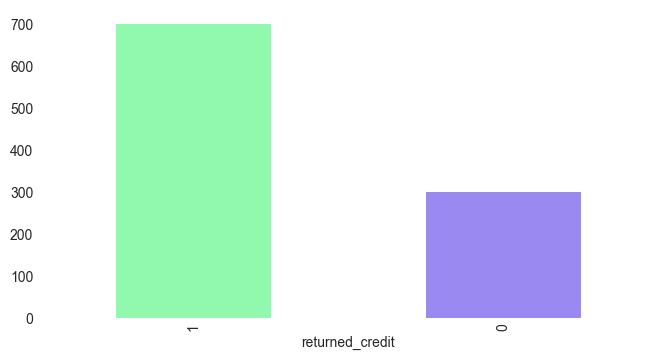

In [18]:
# Carga del dataset para el entendimiento de los modelos de clasificación
df = pd.read_csv('credit_practice_dataset.csv')


print('\nDISTRIBUCION DE CLASES:')
print(df['returned_credit'].value_counts())
print('\nProporcion:')
print(df['returned_credit'].value_counts(normalize=True))

plt.figure(figsize=(8,4))

# Gráfico de barras para la distribución de clases
ax = df['returned_credit'].value_counts().plot(kind='bar', color=["#91F9AD", "#9B89F2"])

# Cuadrícula solo en las líneas del eje Y (lo que se usa en un barplot vertical)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.show()



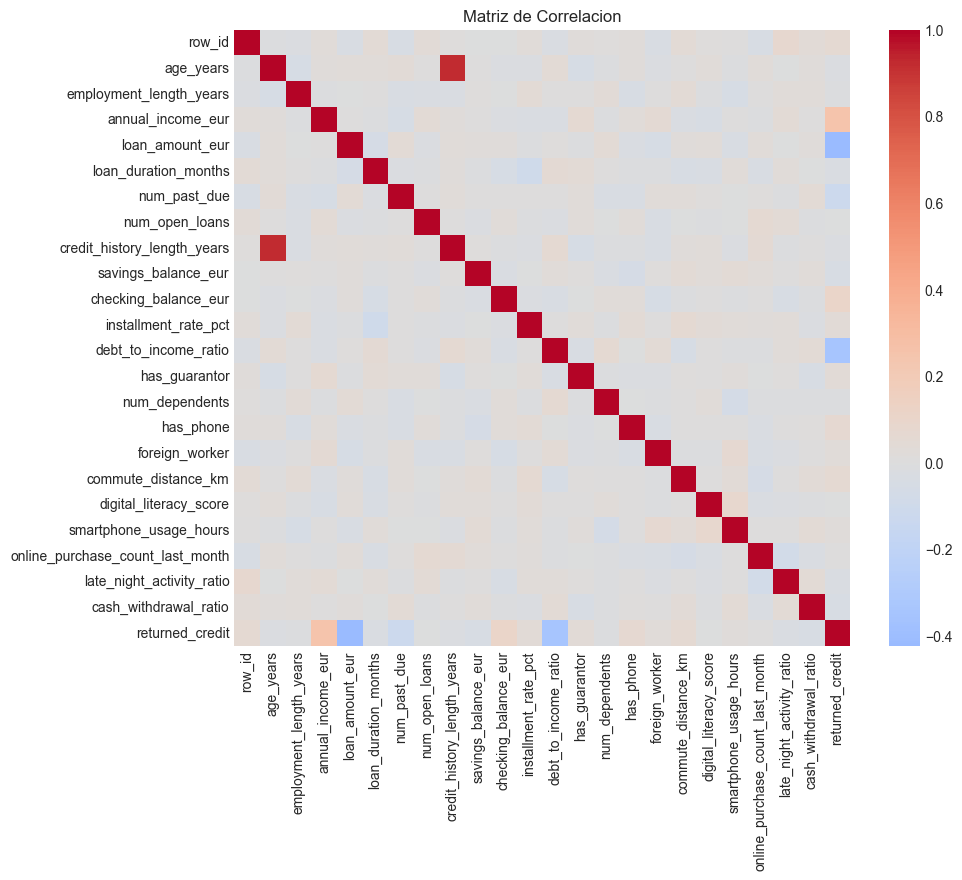

In [19]:
numeric_df = df.select_dtypes(include=[np.number])
# Selecciona solo las columnas numéricas del DataFrame

corr = numeric_df.corr()
# Calcula la matriz de correlación entre las variables numéricas

target_corr = corr['returned_credit'].sort_values(ascending=False)
# Obtiene las correlaciones de todas las variables con la variable objetivo 'returned_credit' y las ordena


# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, annot=False)
plt.title('Matriz de Correlacion')
plt.show()

## Apartado B: Preprocesamiento

In [22]:
# División del dataset en conjuntos de entrenamiento y prueba
X = df.drop(columns=['row_id', 'returned_credit'])
y = df['returned_credit']

# División del dataset en 70% entrenamiento y 30% prueba, manteniendo el balance de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print('DIVISION TRAIN/TEST:')
print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')

# Preprocesamiento de datos 
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
#Selecciona solo las columnas de tipo objeto (string)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
#Selecciona solo las columnas numéricas

numeric_transformer = StandardScaler()
#Normaliza variables numéricas (media 0, varianza 1)

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
#Convierte variables categóricas en variables binarias.

# Combina los transformadores en un preprocesador de columnas para los dos tipos de datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print('Preprocesador creado')

DIVISION TRAIN/TEST:
Train: 700, Test: 300
Preprocesador creado


## Apartado C: Entrenamiento de Modelos Iniciales

**Modelos:** Logistic Regression (C=0.001), Decision Tree, KNN (k=1), Naive Bayes

In [23]:
print('ENTRENAMIENTO DE MODELOS INICIALES')

# Entrenamiento de modelos iniciales con hiperparámetros básicos

# Entrenamiento del modelo de Regresión Logísticas
    # c=0.001 para regularización fuerte y evitar sobreajuste
    # max_iter=1000 para asegurar convergencia
pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.001, max_iter=1000, random_state=42))
])
pipe_lr.fit(X_train, y_train)
print('- Logistic Regression (C=0.001): Listo')

# Entrenamiento del modelo de Árbol de Decisión sin límite de profundidad
    # Utiliza class_weight='balanced' para manejar clases desbalanceadas
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])
pipe_dt.fit(X_train, y_train)
print('- Decision Tree (sin limite profundidad): Listo')

# Entrenamiento del modelo KNN con k=1
    # k=1 para considerar el vecino más cercano
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=1))
])
pipe_knn.fit(X_train, y_train)
print('- KNN (k=1): Listo')

# Entrenamiento del modelo Naive Bayes Gaussiano
    # Asume que las características siguen una distribución normal
pipe_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])
pipe_nb.fit(X_train, y_train)
print('- Naive Bayes: Listo')

#Modelos entrenados almacenados en un diccionario para mejor accesos
models = {
    'Logistic Regression': pipe_lr,
    'Decision Tree': pipe_dt,
    'KNN': pipe_knn,
    'Naive Bayes': pipe_nb
}

ENTRENAMIENTO DE MODELOS INICIALES
- Logistic Regression (C=0.001): Listo
- Decision Tree (sin limite profundidad): Listo
- KNN (k=1): Listo
- Naive Bayes: Listo


## Apartado D: Evaluacion Inicial

In [ ]:
# Evaluación de modelos iniciales
results_initial = []

# Evaluación de cada modelo y almacenamiento de métricas
# Calcula precisión en entrenamiento y prueba, diferencia y ROC-AUC#
for name, model in models.items():

    # Obtener predicciones y probabilidades:
        #y_pred_train Predicciones en el conjunto de entrenamiento
        #y_pred_test Predicciones en el conjunto de prueba
        #y_prob_test Probabilidades positivas en el conjunto de prueba
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_prob_test = model.predict_proba(X_test)[:, 1]
    
    # Calcular métricas de evaluación:
        #acc_train Precisión en el conjunto de entrenamiento
        #acc_test Precisión en el conjunto de prueba
        #auc_test Área bajo la curva ROC en el conjunto de pruebas
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_prob_test)
    
    # Almacenar resultados en la lista
    results_initial.append({
        'Modelo': name,
        'Acc_Train': round(acc_train, 4),
        'Acc_Test': round(acc_test, 4),
        'Diferencia': round(acc_train - acc_test, 4),
        'ROC-AUC': round(auc_test, 4)
    })

df_results = pd.DataFrame(results_initial)
print('RESULTADOS MODELOS INICIALES')
print(df_results.to_string(index=False))

RESULTADOS MODELOS INICIALES
             Modelo  Acc_Train  Acc_Test  Diferencia  ROC-AUC
Logistic Regression     0.7029    0.7000      0.0029   0.8608
      Decision Tree     1.0000    0.7767      0.2233   0.7262
                KNN     1.0000    0.7100      0.2900   0.6595
        Naive Bayes     0.7843    0.7300      0.0543   0.7660


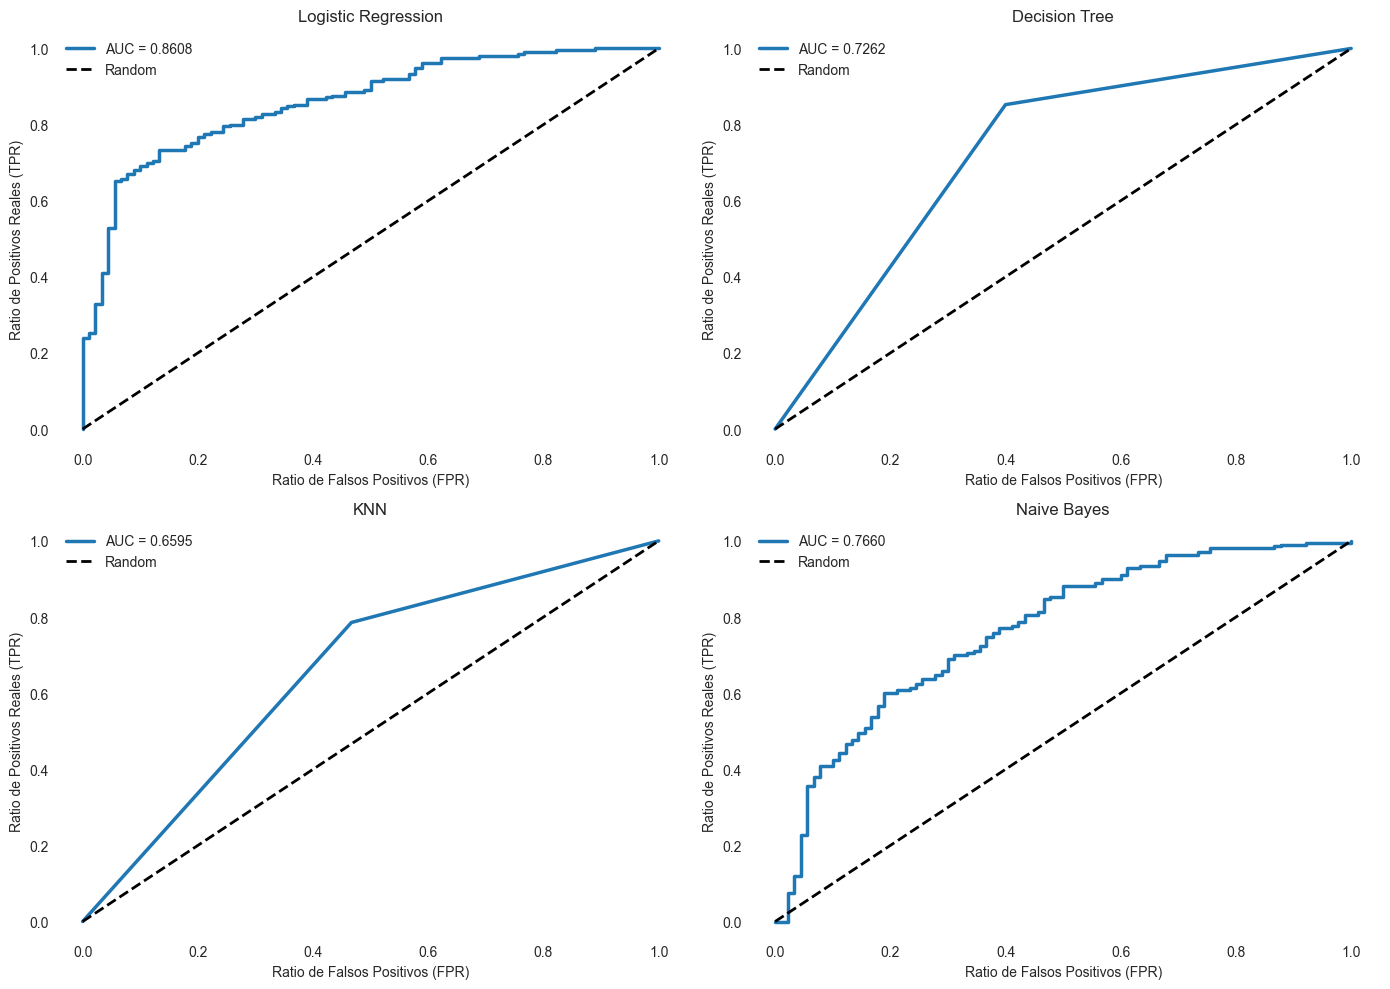

In [25]:
# Visualización de las curvas ROC para cada modelo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# Generación y plot de curvas ROC para cada modelo
for idx, (name, model) in enumerate(models.items()):

    # Obtener probabilidades positivas para el conjunto de prueba
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    # Plot de la curva ROC
    axes[idx].plot(fpr, tpr, lw=2.5, label=f'AUC = {auc:.4f}')
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    axes[idx].set_xlabel('Ratio de Falsos Positivos (FPR)')
    axes[idx].set_ylabel('Ratio de Positivos Reales (TPR)')
    axes[idx].set_title(name)
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()